In [7]:
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.metrics import recall_score, roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from sklearn.base import clone
from rfpimp import *
import collections as c
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
rf_model = pickle.load(open('random_forest_completion_third_quarter.p', 'rb')) # load the model

In [9]:
# model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#             max_depth=20, max_features='auto', max_leaf_nodes=None,
#             min_impurity_decrease=0.0, min_impurity_split=None,
#             min_samples_leaf=1, min_samples_split=2,
#             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
#             oob_score=False, random_state=None, verbose=0,
#             warm_start=False)

In [10]:
def standard_confusion_matrix(y_true, y_pred):
    """Make confusion matrix with format:
                  -----------
                  | TP | FP |
                  -----------
                  | FN | TN |
                  -----------
    Parameters
    ----------
    y_true : ndarray - 1D
    y_pred : ndarray - 1D

    Returns
    -------
    ndarray - 2D
    """
    [[tn, fp], [fn, tp]] = confusion_matrix(y_true, y_pred)
    return np.array([[tp, fp], [fn, tn]])

def print_roc_curve(y_test, probabilities, model_type):
    '''
    Calculates and prints a ROC curve given a set of test classes and probabilities from a trained classifier
    '''
    tprs, fprs, thresh = roc_curve(y_test, probabilities)
    plt.figure(figsize=(12,10))
    plt.plot(fprs, tprs, 
         label=model_type, 
         color='red')
    plt.plot([0,1],[0,1], 'k:')
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve AUC: {} Recall: {}".format(roc_auc, recall))
    plt.show()

In [11]:
# X_train = pd.read_csv('../data/processed/first_half/X_train.csv')
# y_train = pd.read_csv('../data/processed/first_half/y_train.csv')
# y_train = y_train['module_not_completed']
X_test = pd.read_csv('../data/processed/third_quarter/X_test.csv')

y_test = pd.read_csv('../data/processed/third_quarter/y_test.csv')
y_test = y_test['module_not_completed']

# fill
# X_train.fillna(value = 0, inplace = True)
# X_train = scale_subset(X_train, numeric_cols)
X_test.fillna(value = 0, inplace = True)

In [12]:
    predictions = rf_model.predict(X_test)
    roc_auc = roc_auc_score(y_test, predictions)
    probas = rf_model.predict_proba(X_test)[:, :1]
    tprs, fprs, thresh = roc_curve(y_test, probas)
    recall = recall_score(y_test, predictions)
    conf_mat = standard_confusion_matrix(y_test, predictions)
    class_report = classification_report(y_test, predictions)

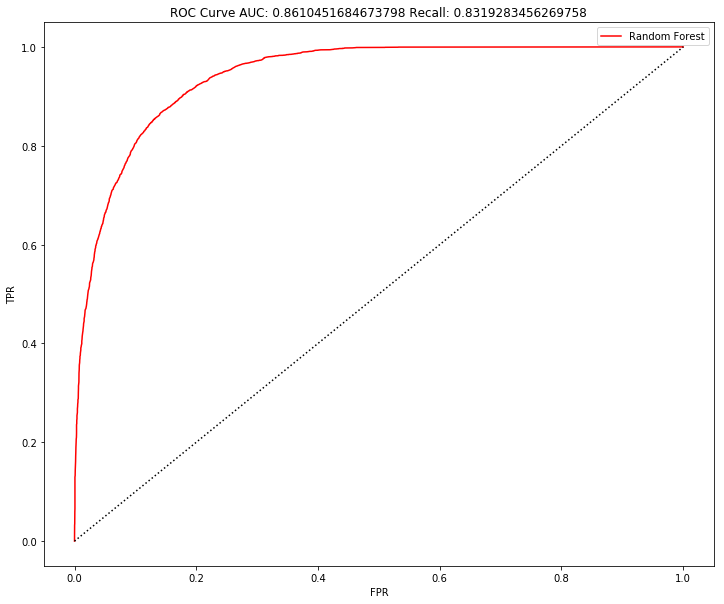

Best Model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Roc Auc: 0.8610451684673798

Recall Score: 0.8319283456269758

Classification Report:
               precision    recall  f1-score   support

       False       0.82      0.89      0.86      5062
        True       0.89      0.83      0.86      5694

   micro avg       0.86      0.86      0.86     10756
   macro avg       0.86      0.86      0.86     10756
weighted avg       0.86      0.86      0.86     10756


Confusion Matrix:
 [[4737  556]
 [ 957 4506]]


In [13]:
    print_roc_curve(y_test, probas, 'Random Forest')
    print('Best Model: {}'.format(rf_model))
    print('\nRoc Auc: {}'.format(roc_auc))
    print('\nRecall Score: {}'.format(recall))
    print('\nClassification Report:\n {}'.format(class_report))
    print('\nConfusion Matrix:\n {}'.format(standard_confusion_matrix(y_test, predictions)))

In [14]:
feat_imp = importances(rf_model, X_test, y_test)

In [15]:
feat_imp.sort_values(by='Importance', ascending=False)[0:10]

,Importance
Feature,
avg_score,0.0560
sum_click_quiz,0.0180
sum_days_vle_accessed,0.0166
sum_click_oucontent,0.0060
max_clicks_one_day,0.0038
code_module_FFF,0.0034
avg_days_sub_early,0.0034
first_date_vle_accessed,0.0028
module_presentation_length,0.0022


In [16]:
pd.DataFrame(data={'fprs': fprs, 'tprs': tprs, 'Thresholds': thresh}).loc[300:1000:25]

,fprs,tprs,Thresholds
300,0.069898,0.726393,0.689
325,0.079733,0.752272,0.664
350,0.091675,0.783090,0.639
375,0.102740,0.810747,0.613
400,0.116614,0.832675,0.586
425,0.129259,0.851047,0.561
450,0.144362,0.869024,0.534
475,0.162100,0.884828,0.508
500,0.178258,0.901422,0.483
525,0.192483,0.913275,0.458
